LOAD RAW PATENT DATASET

In [1]:
import pandas as pd
import numpy as np

In [2]:

CSV_PATH = "/Users/jonathan/Desktop/patent_export/ml_patent_base.csv"

CSV_PATH

'/Users/jonathan/Desktop/patent_export/ml_patent_base.csv'

In [3]:
%%time

chunks = []
chunk_size = 200_000

for chunk in pd.read_csv(CSV_PATH, chunksize=chunk_size, low_memory=False):
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

df.head()

CPU times: user 19.5 s, sys: 3.67 s, total: 23.2 s
Wall time: 24 s


,patent_id,patent_type,patent_date,wipo_kind,num_claims,withdrawn,filename,patent_year,patent_month,patent_day,...,title_length,filename_length,wipo_kind_numeric,time_to_issue_days,cpc_section_breadth,early_cpc_flag,assignee_is_company,assignee_is_individual,influence_score,is_summer_grant
0,8769860,utility,2014-07-08,B2,24,f,ipg140708.xml,2014,7,8,...,13,13,2.0,1056.0,NaN,1,NaN,NaN,-6,1
1,D989886,design,2023-06-20,S1,1,f,ipg230620.xml,2023,6,20,...,13,13,1.0,646.0,NaN,0,NaN,NaN,-12,1
2,D962054,design,2022-08-30,S1,1,f,ipg220830.xml,2022,8,30,...,13,13,1.0,454.0,NaN,0,NaN,NaN,-18,1
3,D998476,design,2023-09-12,S1,1,f,ipg230912.xml,2023,9,12,...,13,13,1.0,685.0,NaN,0,NaN,NaN,-5,0
4,D998840,design,2023-09-12,S1,1,f,ipg230912.xml,2023,9,12,...,13,13,1.0,112.0,NaN,0,NaN,NaN,-5,0


BASIC DATA INSPECTION

In [4]:
df.info()
df.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9256345 entries, 0 to 9256344
Data columns (total 34 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   patent_id               object 
 1   patent_type             object 
 2   patent_date             object 
 3   wipo_kind               object 
 4   num_claims              int64  
 5   withdrawn               object 
 6   filename                object 
 7   patent_year             int64  
 8   patent_month            int64  
 9   patent_day              int64  
 10  filing_date_parsed      object 
 11  filing_year             float64
 12  filing_month            float64
 13  filing_day              float64
 14  inventor_count          int64  
 15  assignee_count          int64  
 16  citations_made          int64  
 17  citations_received      int64  
 18  cpc_count               int64  
 19  uspc_count              int64  
 20  has_assignee            int64  
 21  multiple_inventors      int64  

primary_cpc_section       5742821
cpc_section_breadth       5742639
wipo_kind_numeric         2619917
assignee_is_individual    1003752
assignee_is_company       1003752
time_to_issue_days           2259
filing_date_parsed           2259
filing_year                  2259
filing_month                 2259
filing_day                   2259
patent_id                       0
title_length                    0
multiple_inventors              0
withdrawn_flag                  0
filename_length                 0
uspc_count                      0
early_cpc_flag                  0
influence_score                 0
has_assignee                    0
citations_received              0
cpc_count                       0
patent_type                     0
citations_made                  0
assignee_count                  0
inventor_count                  0
patent_day                      0
patent_month                    0
patent_year                     0
filename                        0
withdrawn     

DATA CLEANING AND PREPROCESSING

In [ ]:
import pandas as pd
import numpy as np

df_clean = df.copy()

df_clean["patent_date"] = pd.to_datetime(df_clean["patent_date"], errors="coerce")
df_clean["filing_date_parsed"] = pd.to_datetime(df_clean["filing_date_parsed"], errors="coerce")
df_clean = df_clean[df_clean["patent_date"].notna()]

df_clean["assignee_is_company"] = df_clean["assignee_is_company"].fillna(0).astype(int)
df_clean["assignee_is_individual"] = df_clean["assignee_is_individual"].fillna(0).astype(int)
df_clean["withdrawn_flag"] = df_clean["withdrawn_flag"].fillna(0).astype(int)

df_clean["primary_cpc_section"] = df_clean["primary_cpc_section"].fillna("None")

df_clean["time_to_issue_days"] = df_clean["time_to_issue_days"].fillna(-1)
df_clean = df_clean[
    (df_clean["time_to_issue_days"] > 0) &
    (df_clean["time_to_issue_days"] < 4000)
]

numeric_cols = [
    "num_claims", "inventor_count", "assignee_count",
    "citations_received", "citations_made",
    "cpc_count", "uspc_count"
]

for col in numeric_cols:
    df_clean[col] = df_clean[col].fillna(0)
    df_clean = df_clean[df_clean[col] >= 0]

df_clean["is_post_aia"] = (df_clean["filing_year"] >= 2013).astype(int)

cols_to_drop = [
    "filename",
    "withdrawn",
    "filename_length",
    "wipo_kind_numeric",
    "cpc_section_breadth"
]

df_clean = df_clean.drop(columns=cols_to_drop, errors="ignore")

print("Final cleaned df_clean shape:", df_clean.shape)

Final cleaned df_clean shape: (9241283, 30)


HIGH IMPACT LABEL

In [ ]:
df_impact = df_clean.copy()

df_impact = df_impact[df_impact["patent_year"] <= 2022]

citation_threshold = df_impact["citations_received"].quantile(0.75)
df_impact["high_impact_flag"] = (df_impact["citations_received"] >= citation_threshold).astype(int)

print("High-impact threshold:", citation_threshold)
print("High-impact share:", df_impact["high_impact_flag"].mean())
print("Impact rows:", df_impact.shape)

High-impact threshold: 14.0
High-impact share: 0.2573293629730921
Impact rows: (8336775, 31)


EXTRA FEATURE ENGINEERING

In [ ]:
df_extra = df_impact.copy()

leak_cols = ['patent_id', 'patent_date', 'filing_date_parsed',
             'citations_received', 'citations_made', 'influence_score']
df_extra = df_extra.drop(columns=leak_cols, errors='ignore')

df_extra['complexity_score'] = (
    df_extra['num_claims'] * 0.4 +
    df_extra['cpc_count'] * 0.3 +
    df_extra['inventor_count'] * 0.3
)

df_extra['corporate_advantage'] = (
    df_extra['assignee_is_company'] * df_extra['assignee_count']
)

df_extra['tech_era'] = np.where(
    df_extra['patent_year'] >= 2010, 'modern',
    np.where(df_extra['patent_year'] >= 2000, 'transition', 'legacy')
)

df_extra['processing_efficiency'] = (
    df_extra['num_claims'] / (df_extra['time_to_issue_days'] + 1)
)

df_extra['team_synergy'] = (
    df_extra['inventor_count'] * df_extra['assignee_count']
)

df_extra['claim_density'] = (
    df_extra['num_claims'] / (df_extra['inventor_count'] + 1)
) * df_extra['cpc_count']

df_extra['years_since_filing'] = (
    df_extra['patent_year'] - df_extra['filing_year']
)
df_extra['recent_patent'] = (df_extra['patent_year'] >= 2015).astype(int)

df_extra['title_complexity'] = np.where(
    df_extra['title_length'] > df_extra['title_length'].quantile(0.75), 2,
    np.where(df_extra['title_length'] > df_extra['title_length'].median(), 1, 0)
)

print("extra features added:", df_extra.shape)

extra features added: (8336775, 34)


FEATURE SELECTION

In [ ]:
all_features = [
    'patent_year', 'num_claims', 'primary_cpc_section', 'patent_type',
    'cpc_count', 'filing_year', 'wipo_kind', 'uspc_count', 'time_to_issue_days',
    'complexity_score', 'corporate_advantage', 'tech_era', 'processing_efficiency',
    'team_synergy', 'claim_density', 'years_since_filing', 'recent_patent',
    'title_complexity', 'inventor_count', 'assignee_count', 'assignee_is_company',
    'title_length', 'is_post_aia', 'early_cpc_flag'
]

use_features = [f for f in all_features if f in df_extra.columns]

X_extra = df_extra[use_features].copy()
y_extra = df_extra['high_impact_flag'].copy()

for col in X_extra.columns:
    if X_extra[col].isnull().any():
        if X_extra[col].dtype == 'object':
            X_extra[col] = X_extra[col].fillna('Missing')
        else:
            X_extra[col] = X_extra[col].fillna(X_extra[col].median())

print("feature set shape:", X_extra.shape)
print("features:", X_extra.columns.tolist())

feature set shape: (8336775, 24)
features: ['patent_year', 'num_claims', 'primary_cpc_section', 'patent_type', 'cpc_count', 'filing_year', 'wipo_kind', 'uspc_count', 'time_to_issue_days', 'complexity_score', 'corporate_advantage', 'tech_era', 'processing_efficiency', 'team_synergy', 'claim_density', 'years_since_filing', 'recent_patent', 'title_complexity', 'inventor_count', 'assignee_count', 'assignee_is_company', 'title_length', 'is_post_aia', 'early_cpc_flag']


MODEL TRAINING

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

sample_size = min(700000, len(X_extra))
df_sample = pd.concat([X_extra, y_extra], axis=1).sample(sample_size, random_state=42)

X_sample = df_sample.drop(columns=['high_impact_flag'])
y_sample = df_sample['high_impact_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample,
    test_size=0.15,
    stratify=y_sample,
    random_state=42
)

print("train shape:", X_train.shape)

cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print("categorical cols:", cat_cols)

model = CatBoostClassifier(
    iterations=1200,
    depth=10,
    learning_rate=0.04,
    l2_leaf_reg=2,
    random_strength=0.8,
    bagging_temperature=0.8,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=[1, 4.0],
    early_stopping_rounds=80,
    random_seed=42,
    verbose=100,
    thread_count=-1
)

print("Model training below:")
model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=(X_test, y_test),
    verbose=100
)

train shape: (595000, 24)
categorical cols: ['primary_cpc_section', 'patent_type', 'wipo_kind', 'tech_era']
training model...
0:	test: 0.7698129	best: 0.7698129 (0)	total: 410ms	remaining: 8m 11s
100:	test: 0.7903048	best: 0.7903048 (100)	total: 56.8s	remaining: 10m 17s
200:	test: 0.7910381	best: 0.7910381 (200)	total: 1m 50s	remaining: 9m 10s
300:	test: 0.7912192	best: 0.7912192 (300)	total: 2m 41s	remaining: 8m 1s
400:	test: 0.7912877	best: 0.7913033 (394)	total: 3m 39s	remaining: 7m 17s
Stopped by overfitting detector  (80 iterations wait)

bestTest = 0.7913033216
bestIteration = 394

Shrink model to first 395 iterations.


FEATURE IMPORTANCE

In [10]:
import pandas as pd

importances = model.get_feature_importance()
feat_names = model.feature_names_

fi = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

fi.head(20)

,feature,importance
0,patent_year,21.277787
6,wipo_kind,14.756192
2,primary_cpc_section,9.551847
5,filing_year,7.479212
9,complexity_score,7.406239
1,num_claims,5.606189
8,time_to_issue_days,4.489363
4,cpc_count,3.651059
3,patent_type,3.160283
18,inventor_count,2.751438


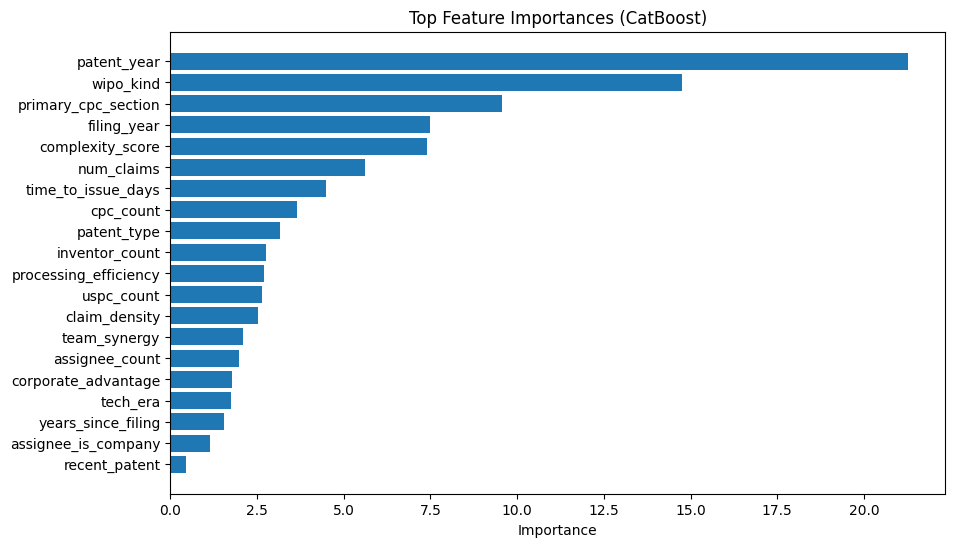

In [11]:
import matplotlib.pyplot as plt

top_n = 20
top_fi = fi.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_fi["feature"], top_fi["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top Feature Importances (CatBoost)")
plt.show()

CONFUSION MATRIX

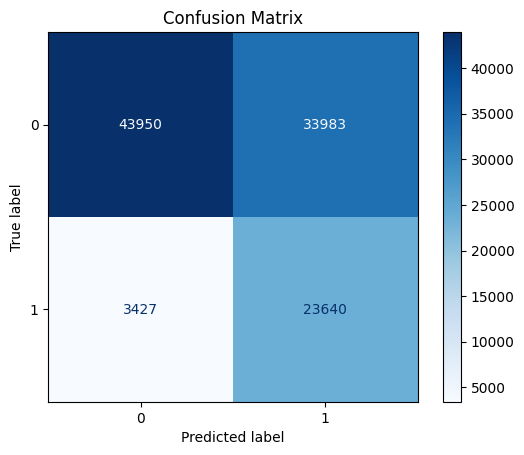

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

NORMALIZED CONFUSION MATRIX

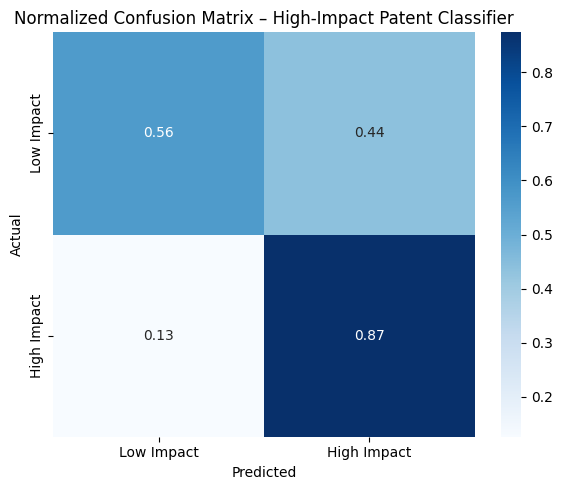

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f",
            xticklabels=["Low Impact", "High Impact"],
            yticklabels=["Low Impact", "High Impact"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix – High-Impact Patent Classifier")
plt.tight_layout()
plt.show()